# Imperfect HWP simulation

Saved residuals to Hamal_residuals_varying_AoLP_0_matrix_noise_5_additive_HWP_noise_0_tint_60_sub_tint_1_readout_noise_0_AoLP_residuals.npy
Saved residuals to Hamal_residuals_varying_AoLP_20_matrix_noise_5_additive_HWP_noise_0_tint_60_sub_tint_1_readout_noise_0_AoLP_residuals.npy
Saved residuals to Hamal_residuals_varying_AoLP_40_matrix_noise_5_additive_HWP_noise_0_tint_60_sub_tint_1_readout_noise_0_AoLP_residuals.npy
Saved residuals to Hamal_residuals_varying_AoLP_60_matrix_noise_5_additive_HWP_noise_0_tint_60_sub_tint_1_readout_noise_0_AoLP_residuals.npy
Saved residuals to Hamal_residuals_varying_AoLP_80_matrix_noise_5_additive_HWP_noise_0_tint_60_sub_tint_1_readout_noise_0_AoLP_residuals.npy
Saved residuals to Hamal_residuals_varying_AoLP_100_matrix_noise_5_additive_HWP_noise_0_tint_60_sub_tint_1_readout_noise_0_AoLP_residuals.npy
Saved residuals to Hamal_residuals_varying_AoLP_120_matrix_noise_5_additive_HWP_noise_0_tint_60_sub_tint_1_readout_noise_0_AoLP_residuals.npy
Saved residu

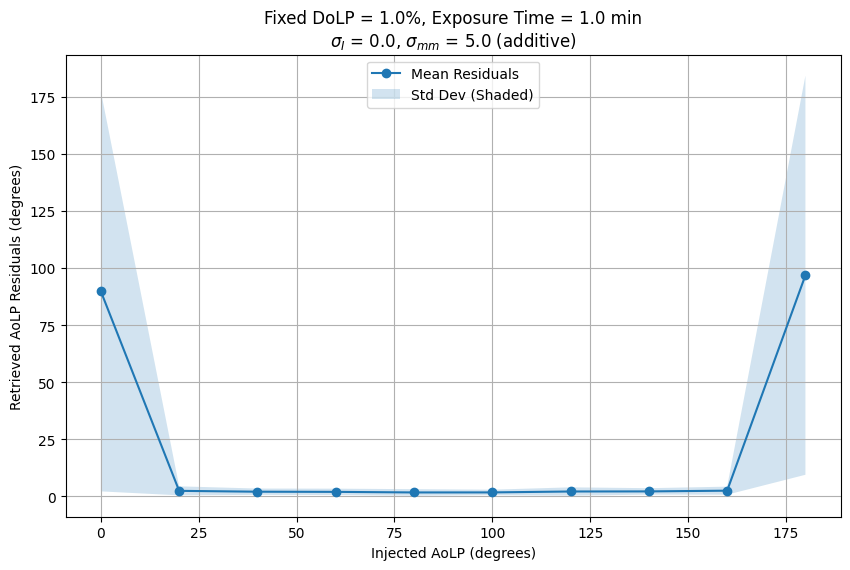

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../python/')
import angles
import instrument_mm

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST
matrix_noise_type = "additive"

# Fixed integration time and sub-integration time
t_int = 1 * 60  # 1 minute in seconds
sub_tint = 1  # 1 second
num_samples = 100

# Injected polarization settings
DoLP = 0.01  # Degree of linear polarization (fixed at 1%)
AoLP_values = np.arange(0, 181, 20)  # Angle of linear polarization from 0 to 180 degrees
noise_percentage = 0  # Intensity noise
matrix_noise = 5  # Fixed matrix noise (5%)

# HWP settings
HWP_noise = 0  # 0% uncertainty on HWP retardance
delta_HWP = 0.5
num_trials = 50  # Number of trials per AoLP value

def aolp_to_stokes(dolp, aolp):
    """
    Converts Degree of Linear Polarization (DoLP) and Angle of Linear Polarization (AoLP) 
    to Stokes Q and U parameters.

    Parameters:
    ----------
    dolp : float
        Degree of linear polarization.
    aolp : float
        Angle of linear polarization in degrees.

    Returns:
    -------
    Q : float
        Stokes Q parameter.
    U : float
        Stokes U parameter.
    """
    aolp_rad = np.radians(aolp)
    Q = dolp * np.cos(2 * aolp_rad)
    U = dolp * np.sin(2 * aolp_rad)
    return Q, U

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over AoLP values
    for aolp in AoLP_values:
        residuals = []

        # Convert AoLP and DoLP to Stokes Q and U
        Q_injected, U_injected = aolp_to_stokes(DoLP, aolp)

        # Perform multiple trials for each AoLP value
        for trial in range(num_trials):
            S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"], 
                dec=target["dec"], 
                observer_latitude=observer_latitude, 
                observer_longitude=observer_longitude, 
                jd_str=observation_date, 
                ut_start=observation_time, 
                t_int=t_int, 
                Q=Q_injected, 
                U=U_injected, 
                delta_HWP=delta_HWP,
                noise_percentage=noise_percentage,
                include_V=False,
                sub_tint=sub_tint,  # Sub-integration time in seconds
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                observable="intensities",  # Or "single_difference" if needed
                sampled_steps=num_samples,
                matrix_noise_type=matrix_noise_type,
                HWP_noise=HWP_noise
            )
            
            # Calculate retrieved polarization
            Q_retrieved, U_retrieved = S_in_retrieved[1], S_in_retrieved[2]

            # Calculate retrieved AoLP
            retrieved_aolp = 0.5 * np.degrees(np.arctan2(U_retrieved, Q_retrieved))
            if retrieved_aolp < 0:
                retrieved_aolp += 180  # Ensure AoLP is between 0 and 180 degrees

            # Calculate AoLP residuals
            residual = np.abs(aolp - retrieved_aolp)
            residuals.append(residual)

        # Compute mean and standard deviation of residuals for this AoLP value
        mean_residuals.append(np.mean(residuals))
        std_residuals.append(np.std(residuals))

        # Save the residuals as a .npy file
        filename = (
            f"{target['name']}_residuals_varying_AoLP_{aolp}_matrix_noise_{matrix_noise}_{matrix_noise_type}_"
            f"HWP_noise_{HWP_noise}_tint_{t_int}_sub_tint_{sub_tint}_"
            f"readout_noise_{noise_percentage}_AoLP_residuals.npy"
        )
        np.save(filename, np.array(residuals))
        print(f"Saved residuals to {filename}")

    # Plot the results for this target
    plt.figure(figsize=(10, 6))
    mean_residuals = np.array(mean_residuals)
    std_residuals = np.array(std_residuals)

    plt.plot(AoLP_values, mean_residuals, '-o', label=f"Mean Residuals")
    plt.fill_between(AoLP_values, mean_residuals - std_residuals, mean_residuals + std_residuals, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel("Injected AoLP (degrees)")
    plt.ylabel("Retrieved AoLP Residuals (degrees)")
    plt.title(
        # f"{target['name']} (Dec: {target['dec']}°)\n"
        f"Fixed DoLP = {DoLP * 100:.1f}%, Exposure Time = {t_int / 60:.1f} min\n"
        f"$\sigma_I$ = {noise_percentage:.1f}, $\sigma_{{mm}}$ = {matrix_noise:.1f} ({matrix_noise_type})"
    )
    plt.grid(True)
    plt.legend()
    plt.show()


# Regenerating Plots

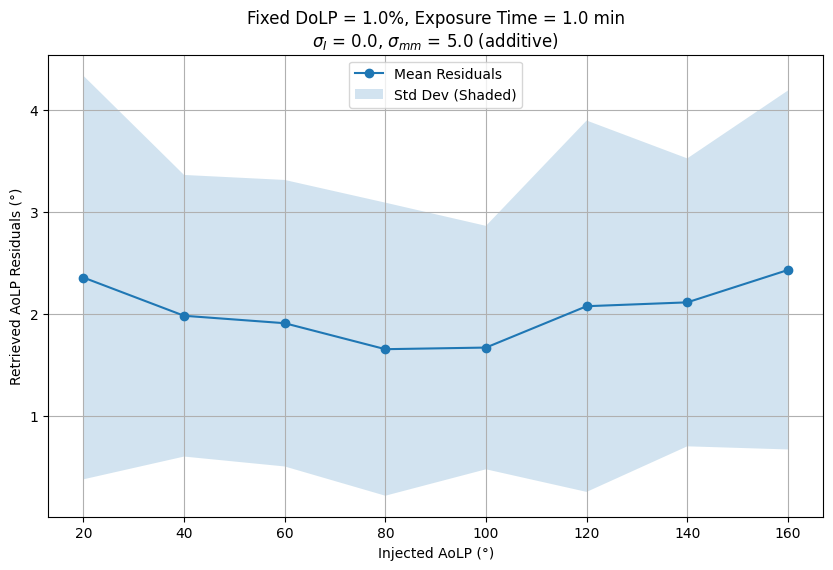

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
]

# Injected polarization settings
DoLP = 0.01  # Degree of linear polarization (fixed at 1%)
AoLP_values = np.arange(0, 181, 20)  # Angle of linear polarization from 0 to 180 degrees
t_int = 1 * 60  # Integration time in seconds
sub_tint = 1  # Sub-integration time in seconds
noise_percentage = 0  # Intensity noise
matrix_noise = 5  # Fixed matrix noise (5%)
matrix_noise_type = "additive"
HWP_noise = 0  # 0% uncertainty on HWP retardance

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over AoLP values
    for aolp in AoLP_values[1:-1]:  # Exclude the first and last points
        # Load saved residuals
        filename = (
            f"{target['name']}_residuals_varying_AoLP_{aolp}_matrix_noise_{matrix_noise}_{matrix_noise_type}_"
            f"HWP_noise_{HWP_noise}_tint_{t_int}_sub_tint_{sub_tint}_"
            f"readout_noise_{noise_percentage}_AoLP_residuals.npy"
        )
        residuals = np.load(filename)
        mean_residuals.append(np.mean(residuals))
        std_residuals.append(np.std(residuals))

    # Adjust AoLP values to exclude first and last points
    trimmed_aolp_values = AoLP_values[1:-1]

    # Plot the results for this target
    plt.figure(figsize=(10, 6))
    mean_residuals = np.array(mean_residuals)
    std_residuals = np.array(std_residuals)

    plt.plot(trimmed_aolp_values, mean_residuals, '-o', label=f"Mean Residuals")
    plt.fill_between(trimmed_aolp_values, mean_residuals - std_residuals, mean_residuals + std_residuals, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel("Injected AoLP (°)")
    plt.ylabel("Retrieved AoLP Residuals (°)")
    plt.title(
        f"Fixed DoLP = {DoLP * 100:.1f}%, Exposure Time = {t_int / 60:.1f} min\n"
        f"$\sigma_I$ = {noise_percentage:.1f}, $\sigma_{{mm}}$ = {matrix_noise:.1f} ({matrix_noise_type})"
    )
    plt.grid(True)
    plt.legend()
    plt.show()
